# Stock Classification using k-means clustering

K-means algorithm for stock classification analysis


In [1]:
import pathlib
import sys
import os
import logging
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
from tabulate import tabulate
from sklearn.cluster import KMeans 
from sklearn import preprocessing

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO, stream=sys.stdout)

In [4]:
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

#### Global variables

In [5]:
from tsa.config import DATA_DIR

In [6]:
# DATA_DIR = os.getenv('DATA_DIR', os.path.join(os.path.expanduser('~'), r'Data/quant/prices'))

'/Users/yevgeniy/Development/projects/anomaly/time-series-analysis/data'

In [7]:

HISTORICAL_PRICES_5_YRS = os.path.join(DATA_DIR, 'prices_5yrs.csv')
HISTORICAL_PRICES_10_YRS = os.path.join(DATA_DIR, 'prices_10yrs.csv')
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE']

In [19]:
fpath = HISTORICAL_PRICES_10_YRS
df_prices = pd.read_csv(fpath, parse_dates=['date'], index_col=0)

## EDA

#### Loading prices

In [20]:
print(tabulate(df_prices.head(5), headers="keys"))

date                 ticker       open     high      low    close     volume
-------------------  --------  -------  -------  -------  -------  ---------
2011-04-11 00:00:00  AAPL      10.2767  10.3262  10.1524  10.1764  398946800
2011-04-12 00:00:00  AAPL      10.1669  10.2665  10.1579  10.2256  425639200
2011-04-13 00:00:00  AAPL      10.3062  10.3407  10.2293  10.3404  346220000
2011-04-14 00:00:00  AAPL      10.2994  10.3364  10.2152  10.2262  301800800
2011-04-15 00:00:00  AAPL      10.2533  10.2638  10.0533  10.0736  453605600


In [21]:
all_tickers = df_prices.ticker.unique().tolist()
all_tickers

['AAPL', 'MSFT', 'AMZN', 'GOOG', 'FB', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']

### Adding Returns

We calculate the annual average return and volatility for each company by obtaining their adjusted closing prices,  which is then annualized (assuming 252 market days per year).

In [22]:
df_prices['pct_change'] = df_prices['close'].pct_change()
df_prices['returns'] = df_prices['close'].pct_change().mean() * 252
df_prices['volatility'] = df_prices['close'].pct_change().std() * sqrt(252)

In [23]:
df_prices.head()

,ticker,open,high,low,close,volume,pct_change,returns,volatility
date,,,,,,,,,
2011-04-11,AAPL,10.276680,10.326208,10.152399,10.176394,398946800,NaN,0.241695,0.436805
2011-04-12,AAPL,10.166857,10.266530,10.157936,10.225616,425639200,0.004837,0.241695,0.436805
2011-04-13,AAPL,10.306213,10.340668,10.229306,10.340361,346220000,0.011221,0.241695,0.436805
2011-04-14,AAPL,10.299446,10.336361,10.215156,10.226230,301800800,-0.011037,0.241695,0.436805
2011-04-15,AAPL,10.253298,10.263758,10.053340,10.073643,453605600,-0.014921,0.241695,0.436805


###  Determine the optimal number of clusters

The Elbow curve method is a technique used to determine the optimal number of clusters for K-means clustering. The method works by plotting the sum of squared errors (SSE) for different values of k (number of clusters). The optimal number of clusters is the value of k at which the SSE starts to decrease at a slower rate. The optimal number of clusters is determined by finding the elbow or the point at which the SSE reaches its minimum value. 

In [28]:
# Format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(df_prices['returns']),np.asarray(df_prices['volatility'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))

/Users/yevgeniy/opt/anaconda3/envs/tsa/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yevgeniy/opt/anaconda3/envs/tsa/lib/python3.9/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yevgeniy/opt/anaconda3/envs/tsa/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yevgeniy/opt/anaconda3/envs/tsa/lib/python3.9/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1

<Figure size 1500x500 with 0 Axes>

#### Pivoting prices

In [18]:
df_prices.reset_index(inplace=True)
df_prices = df_prices.pivot(index='date', columns='ticker', values='close')

In [19]:
print(tabulate(df_prices.head(5), headers="keys"))

date                    AAPL    ADBE    AMZN    FB     GOOG      JPM     MSFT     NFLX    TSLA      WMT
-------------------  -------  ------  ------  ----  -------  -------  -------  -------  ------  -------
2011-04-11 00:00:00  10.1764   34.38  184.04   nan  287.607  35.4552  20.7303  32.5943   5.054  41.5827
2011-04-12 00:00:00  10.2256   34.09  180.48   nan  284.24   35.2887  20.459   33.4171   4.93   42.1338
2011-04-13 00:00:00  10.3404   34.21  182.29   nan  287.064  34.9936  20.451   34.1071   4.986  42.2204
2011-04-14 00:00:00  10.2262   34.33  181.82   nan  288.175  34.0252  20.2834  33.8186   5.028  42.118
2011-04-15 00:00:00  10.0736   34.51  180.01   nan  264.359  33.9646  20.2435  33.6414   5.116  42.1574


<Axes: xlabel='date'>

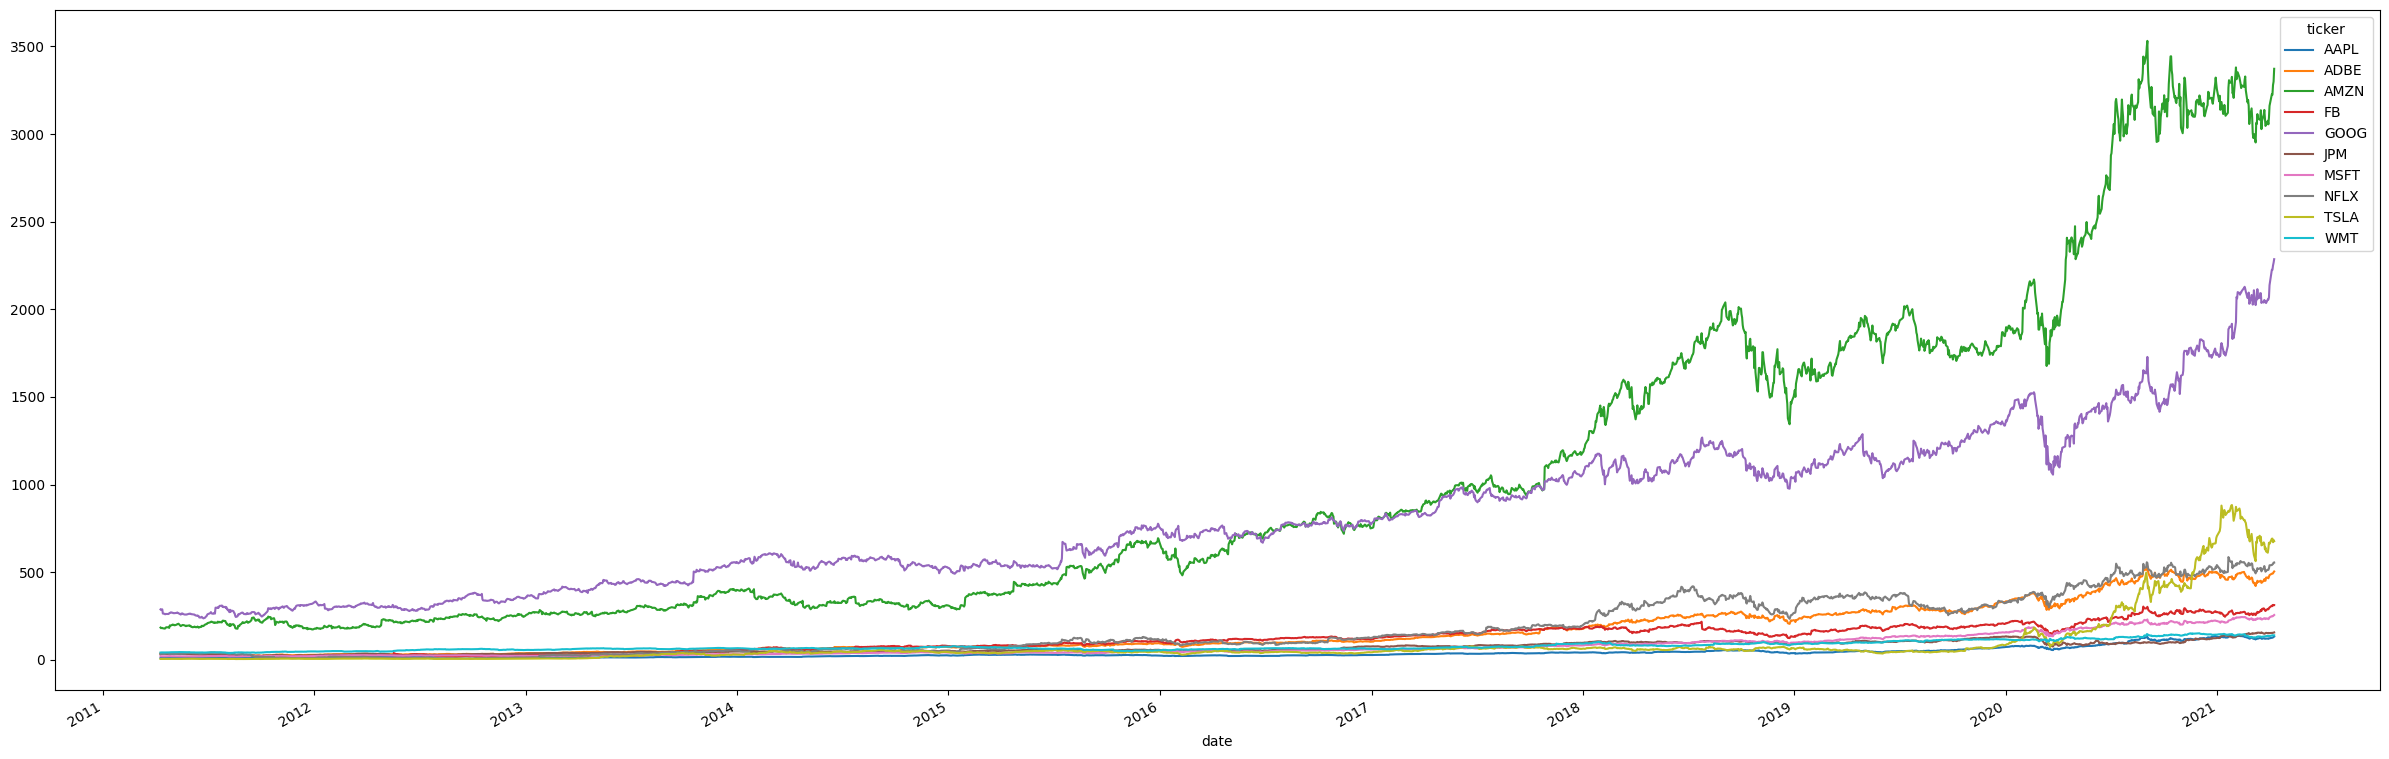

In [20]:
df_prices.plot(figsize=(30, 10))

#### Normalizing result to start with the same prices


In [21]:
df_normalized_prices = (df_prices / df_prices.iloc[0])

<Axes: xlabel='date'>

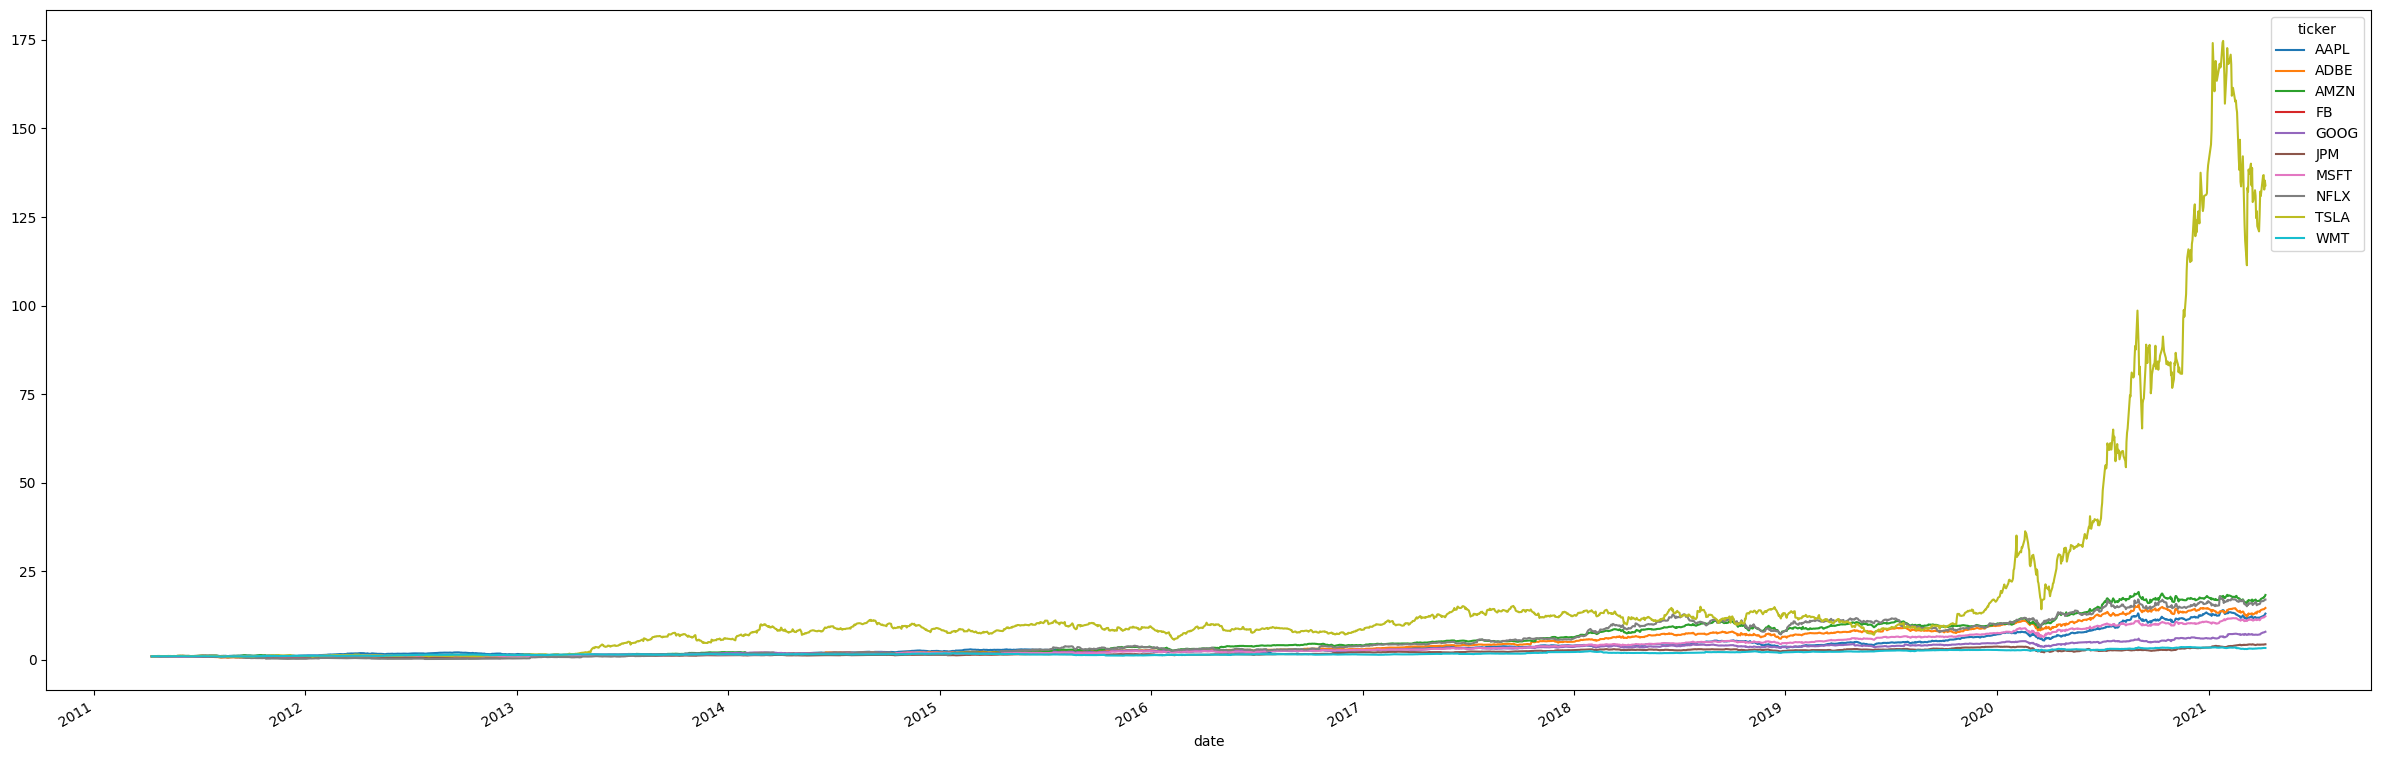

In [22]:
df_normalized_prices.plot(figsize=(30, 10))

#### Calculate log return 

In [23]:
df_return = np.log(1 + df_prices.pct_change())

In [24]:
print(tabulate(df_return[1:5], headers="keys"))

date                        AAPL         ADBE         AMZN    FB         GOOG          JPM          MSFT         NFLX         TSLA           WMT
-------------------  -----------  -----------  -----------  ----  -----------  -----------  ------------  -----------  -----------  ------------
2011-04-12 00:00:00   0.00482522  -0.00847094  -0.0195331    nan  -0.0117773   -0.00470584  -0.0131733     0.024932    -0.024841     0.0131656
2011-04-13 00:00:00   0.0111589    0.00351388   0.00997884   nan   0.00988776  -0.00839699  -0.000389862   0.0204378    0.011295     0.00205319
2011-04-14 00:00:00  -0.0110988    0.00350169  -0.00258156   nan   0.00386209  -0.0280658   -0.0082275    -0.00849681   0.00838827  -0.00242709
2011-04-15 00:00:00  -0.0150336    0.00522943  -0.0100049    nan  -0.0862588   -0.0017805   -0.00196905   -0.0052517    0.0173507    0.000934082


<Axes: xlabel='date'>

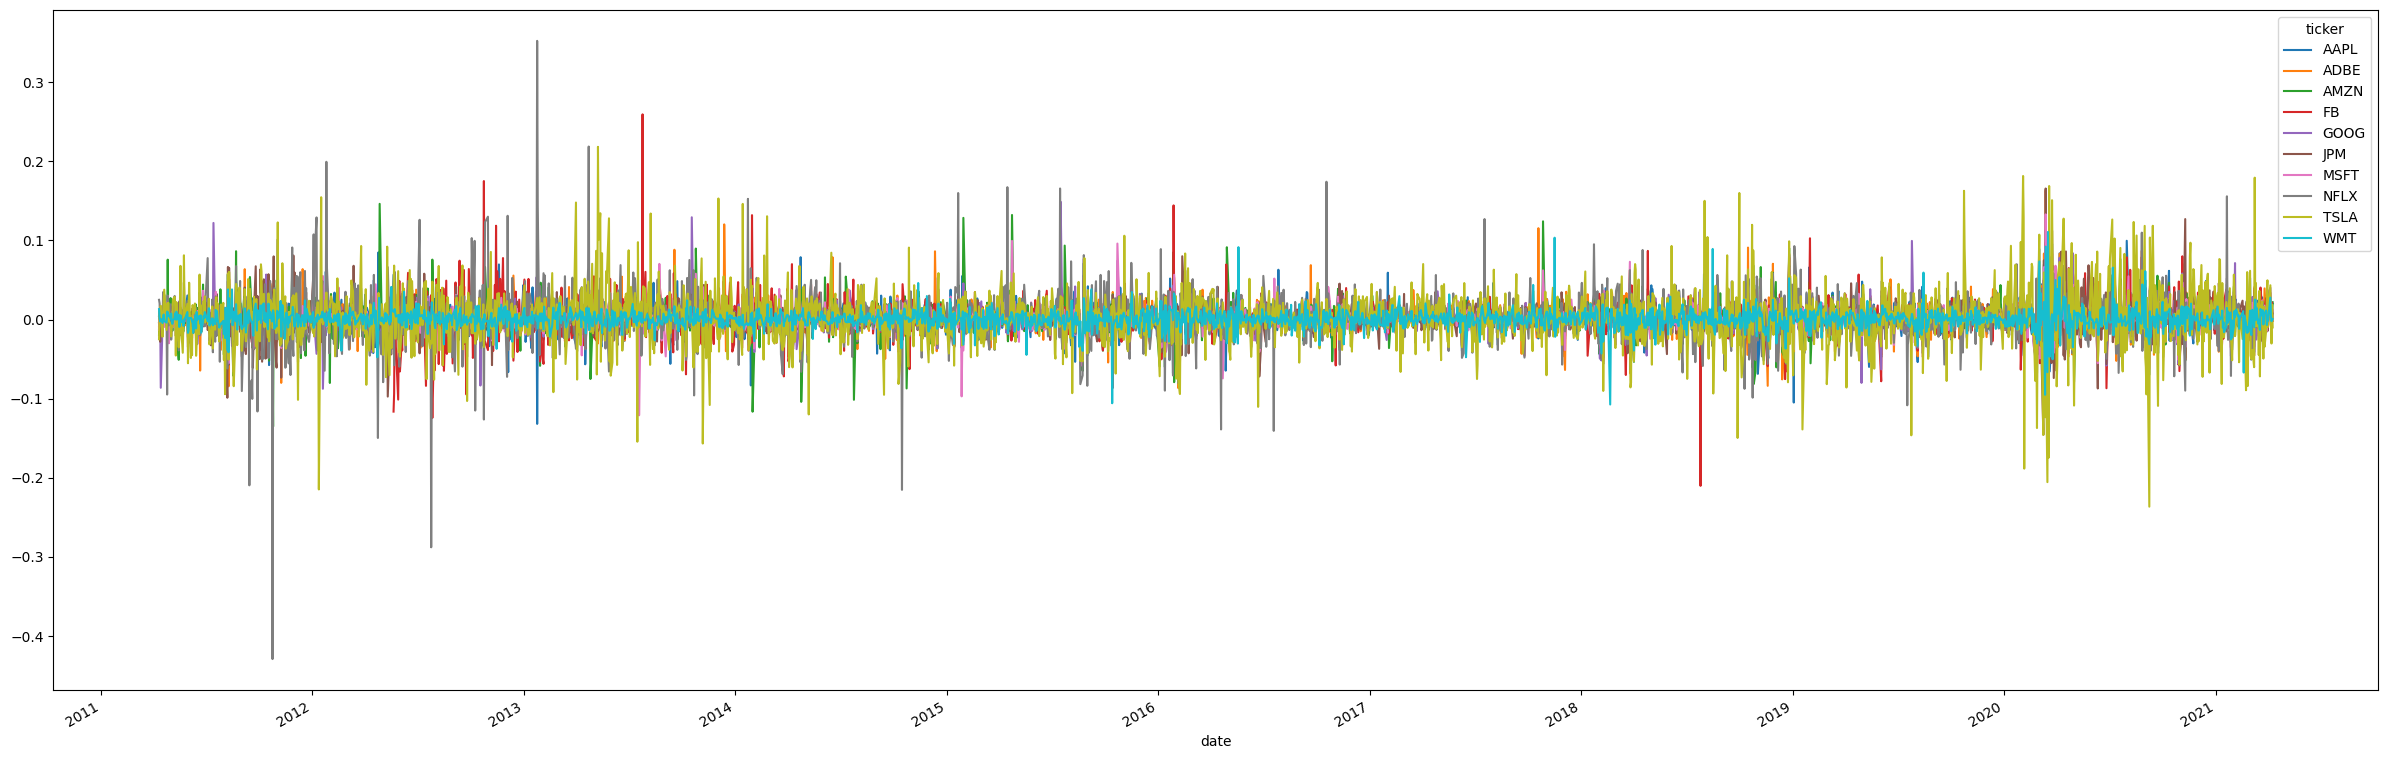

In [25]:
df_return.plot(figsize=(30, 10))

<Axes: xlabel='date'>

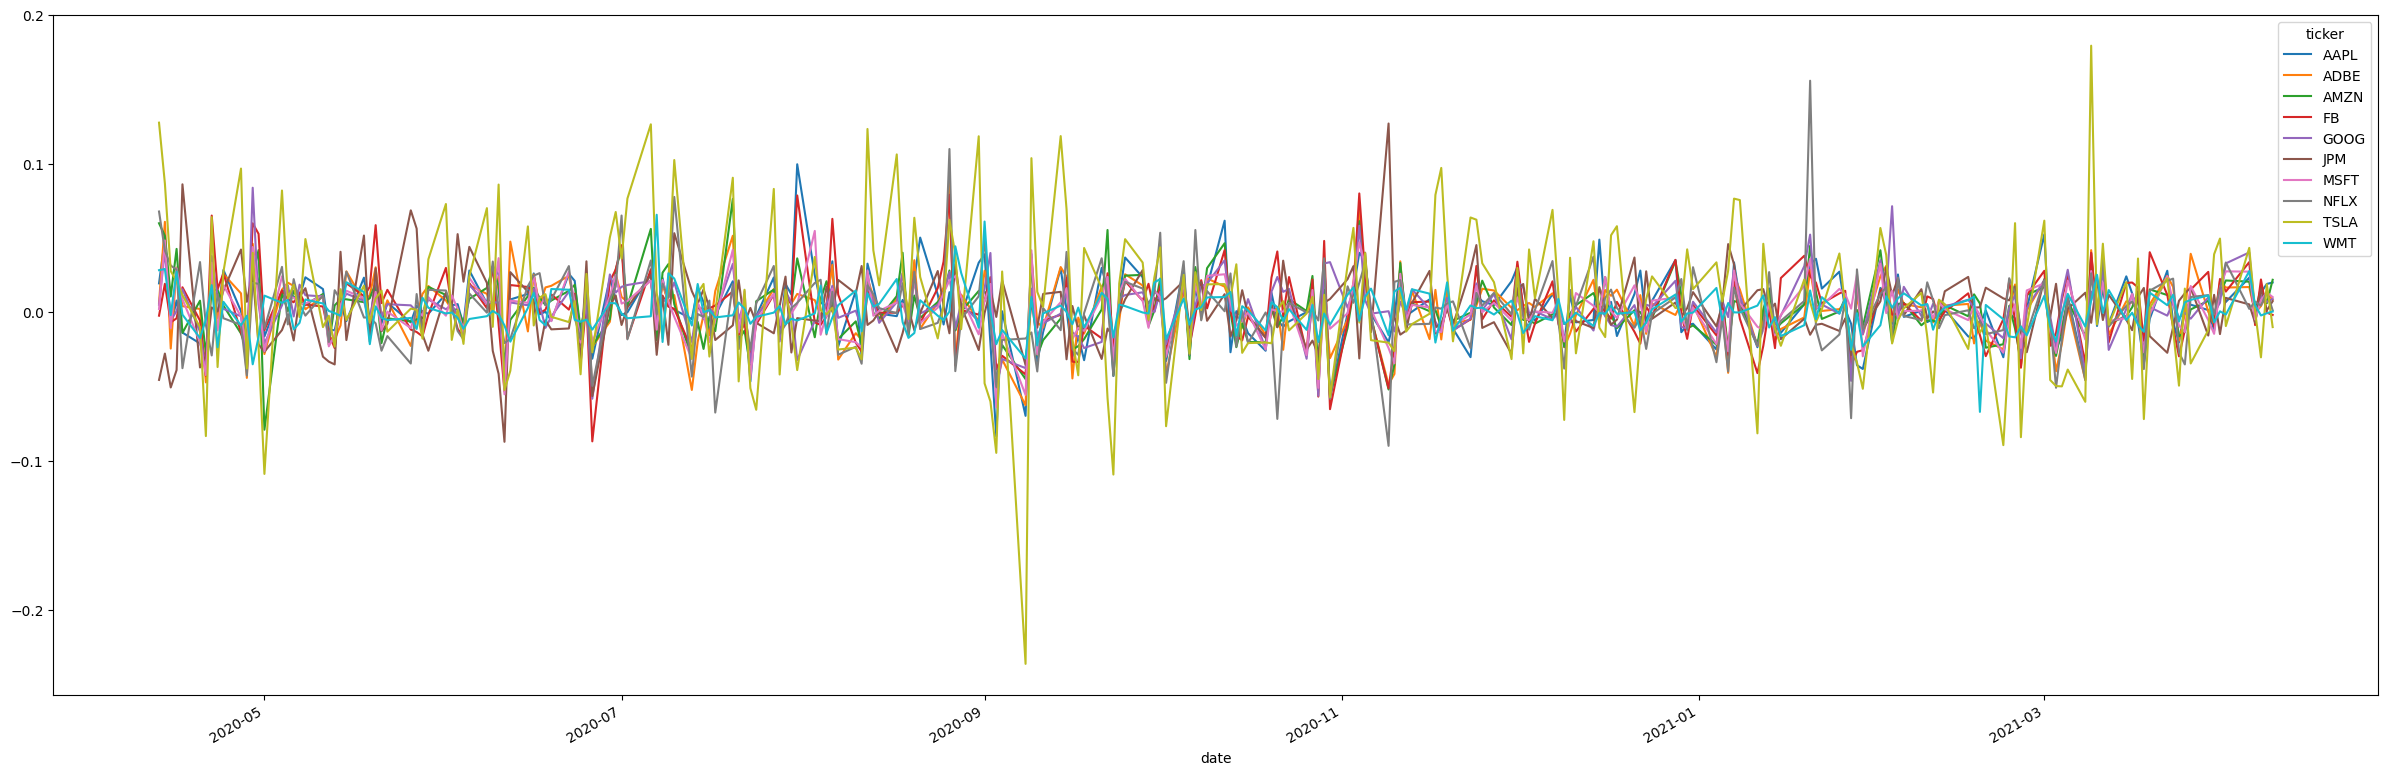

In [26]:
df_return[df_return.index > '2020-04-11'].plot(figsize=(30, 10))

#### Assets correlation
Return correlation between assets using 5 years of returns. The lower the better to find opportunities for diversification.

In [25]:
df_corr = df_return.corr()
df_corr.style.background_gradient(cmap='coolwarm').set_precision(4).set_properties(**{'font-size': '12pt'})

ticker,AAPL,ADBE,AMZN,FB,GOOG,JPM,MSFT,NFLX,TSLA,WMT
ticker,,,,,,,,,,
AAPL,1.0000,0.6460,0.6176,0.5961,0.6549,0.4418,0.7154,0.4645,0.4136,0.3518
ADBE,0.6460,1.0000,0.6770,0.6162,0.7020,0.3898,0.8062,0.5679,0.4197,0.3440
AMZN,0.6176,0.6770,1.0000,0.6213,0.6702,0.2697,0.7076,0.5975,0.3797,0.2916
FB,0.5961,0.6162,0.6213,1.0000,0.6838,0.3548,0.6362,0.4691,0.3350,0.2411
GOOG,0.6549,0.7020,0.6702,0.6838,1.0000,0.4830,0.7812,0.5186,0.3711,0.3168
JPM,0.4418,0.3898,0.2697,0.3548,0.4830,1.0000,0.5020,0.2133,0.2544,0.2588
MSFT,0.7154,0.8062,0.7076,0.6362,0.7812,0.5020,1.0000,0.5390,0.4226,0.4007
NFLX,0.4645,0.5679,0.5975,0.4691,0.5186,0.2133,0.5390,1.0000,0.3352,0.2556
TSLA,0.4136,0.4197,0.3797,0.3350,0.3711,0.2544,0.4226,0.3352,1.0000,0.1630
